In [5]:
import re
from torchvision import transforms
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from transformers import BertModel
import matplotlib.pyplot as plt
import numpy as np

## 1.数据预处理部分

In [6]:
# 文本清理函数
def clean_text(text):
    text = text.lower() # 小写
    text = re.sub(r'\s+', ' ', text)   # 去除多余空格
    text = text.strip() # 去除首尾空格
    return text

# 图像预处理
image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 调整图像大小
    transforms.ToTensor(), # 转换为 PyTorch 张量
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # 标准化参数
        std=[0.229, 0.224, 0.225]
    )
])


In [7]:
# 数据集构建与训练
class MultimodalDataset(Dataset):
    def __init__(self, data_list, image_dir, text_dir, tokenizer, transform=None):
        self.data_list = data_list   # [(guid, label)]
        self.image_dir = image_dir   # 图像文件夹路径
        self.text_dir = text_dir     # 文本文件夹路径
        self.tokenizer = tokenizer   # 文本分词器
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        guid, label = self.data_list[idx]
        # 文本处理
        with open(os.path.join(self.text_dir, f"{guid}.txt"), encoding="Latin-1") as f:
            text = clean_text(f.read())
        # 将清洗后文本转为模型输入格式
        text_input = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # 图像处理
        img_path = os.path.join(self.image_dir, f"{guid}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return {
            "input_ids": text_input["input_ids"].squeeze(0),
            "attention_mask": text_input["attention_mask"].squeeze(0),
            "image": image,
            "label": label
        }

def load_train_data(train_file):
    data = []
    label_map = {
        "negative": 0,
        "neutral": 1,
        "positive": 2
    }
    # 读取训练数据
    with open(train_file, encoding="Latin-1") as f:
        for line in f:
            if line.startswith('guid'): # 跳过表头
                continue 
            guid, label = line.strip().split(',')
            data.append((guid, label_map[label])) # 存入data列表
    return data

def load_test_data(test_file):
    data = []
    # 读取测试数据
    with open(test_file, encoding="Latin-1") as f:
        for line in f:
            if line.startswith('guid'): # 跳过表头
                continue 
            parts = line.strip().split(',')
            guid = parts[0].strip()
            data.append((guid, -1)) # 测试集标签未知，设为-1
    return data

all_data = load_train_data("project5/train.txt")
# 划分训练集和验证集
train_data, val_data = train_test_split(
    all_data,
    test_size=0.2,
    random_state=408,
    stratify=[label for _, label in all_data] # 保持标签分布一致
)
test_data=load_test_data("project5/test_without_label.txt")

In [11]:
# 加载预训练的 BERT 文本编码器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  

train_dataset = MultimodalDataset(
    train_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)

val_dataset = MultimodalDataset(
    val_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)

test_dataset = MultimodalDataset(
    test_data,
    image_dir="project5/data",
    text_dir="project5/data",
    tokenizer=tokenizer,
    transform=image_transform
)
# 数据加载器：训练集 验证集 测试集
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

## 2.特征提取

In [9]:
# 文本编码器（BERT）
class TextEncoder(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super().__init__()
        # 加载预训练的 BERT 模型
        self.bert = BertModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_feat = outputs.last_hidden_state[:, 0, :]  # 提取 [CLS] token的特征
        return cls_feat     # shape: (B, 768)
    
# 图像编码器（ResNet18）
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 加载预训练的 ResNet18 模型
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # 去掉最后的全连接层

    def forward(self, image):
        feat = self.resnet(image)
        return feat     # shape: (B, 512)

In [10]:
# 多模态融合模型
class MultimodalSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 文本与图像编码器
        self.text_encoder = TextEncoder()
        self.image_encoder = ImageEncoder()
        
        # 融合后的分类器
        self.classifier = nn.Sequential(
            nn.Linear(768 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # 新增二级Dropout，进一步抑制过拟合
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # 提取文本和图像特征
        text_feat = self.text_encoder(input_ids, attention_mask)
        image_feat = self.image_encoder(image)
        # 融合特征
        fused_feat = torch.cat([text_feat, image_feat], dim=1)
        # 分类器预测
        logits = self.classifier(fused_feat)
        return logits

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalSentimentModel().to(device)
print(device)
batch = next(iter(train_loader))
logits = model(
    batch["input_ids"].to(device),
    batch["attention_mask"].to(device),
    batch["image"].to(device)
)

print(logits.shape)  # 应该是 (batch_size, 3)


cuda
torch.Size([16, 3])


## 3.网格搜索最优超参数，训练与验证

In [14]:
# 单轮训练
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_batches = len(dataloader)  
    accumulate_steps = 2
    scaler = torch.cuda.amp.GradScaler()

    for batch_idx,batch in enumerate(dataloader):
        optimizer.zero_grad() # 清空梯度
        # 获取数据
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        # 前向传播：混合精度
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            loss = loss / accumulate_steps  # 梯度均分

        # 反向传播：混合精度缩放
        scaler.scale(loss).backward()

        # 每累积2步更新一次参数（等效32batch）
        if (batch_idx + 1) % accumulate_steps == 0 or batch_idx == total_batches - 1:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        '''
        if (batch_idx + 1) % 10 == 0:
            # 当前平均损失：累计损失 / (batch_idx+1)
            current_avg_loss = total_loss / (batch_idx + 1)
            print(f"  Batch [{batch_idx+1}/{total_batches}] | 平均损失：{current_avg_loss:.4f}")
        '''    
        total_loss += loss.item() * accumulate_steps
    torch.cuda.empty_cache()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask, images)
            preds = torch.argmax(logits, dim=1)

            # 计算当前batch的损失
            batch_loss = criterion(logits, labels)  # 计算单batch损失（CrossEntropyLoss会自动求均值）
            total_loss += batch_loss.item() * labels.size(0) 

            # 正确率计算
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total if total > 0 else 0.0
    return correct / total, avg_loss


In [9]:
 # 调超参：学习率 单独5轮
def tune_learning_rate(learning_rates, num_tune_epochs=5):
    tune_results = {
        "lr": [],
        "best_val_acc": [],
        "train_losses_per_epoch": [],
        "val_accs_per_epoch": []
    }

    for lr in learning_rates:
        print(f"\n=== 学习率：{lr} ===")
        # 重新初始化模型
        model = MultimodalSentimentModel(num_classes=3).to(device)
        optimizer = optim.AdamW(
            model.parameters(),lr=lr,weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_accs = []
        best_acc = 0.0

        for epoch in range(num_tune_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_acc = evaluate(model, val_loader, device)

            train_losses.append(train_loss)
            val_accs.append(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc

            print(f" Epoch [{epoch+1}/{num_tune_epochs}] | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 保存结果
        tune_results["lr"].append(lr)
        tune_results["best_val_acc"].append(best_acc)
        tune_results["train_losses_per_epoch"].append(train_losses)
        tune_results["val_accs_per_epoch"].append(val_accs)

        # 清理显存
        torch.cuda.empty_cache()

    return tune_results

learning_rates = [1e-5, 2e-5, 3e-5, 5e-5]
tune_results = tune_learning_rate(learning_rates, num_tune_epochs=5)


=== 学习率：1e-05 ===
 Epoch [1/5] | Train Loss: 0.8006 | Val Acc: 0.7188
 Epoch [2/5] | Train Loss: 0.6017 | Val Acc: 0.7275
 Epoch [3/5] | Train Loss: 0.4545 | Val Acc: 0.7275
 Epoch [4/5] | Train Loss: 0.3078 | Val Acc: 0.7163
 Epoch [5/5] | Train Loss: 0.1971 | Val Acc: 0.7225

=== 学习率：2e-05 ===
 Epoch [1/5] | Train Loss: 0.7952 | Val Acc: 0.6913
 Epoch [2/5] | Train Loss: 0.5331 | Val Acc: 0.7400
 Epoch [3/5] | Train Loss: 0.3306 | Val Acc: 0.7200
 Epoch [4/5] | Train Loss: 0.1718 | Val Acc: 0.7350
 Epoch [5/5] | Train Loss: 0.0887 | Val Acc: 0.7250

=== 学习率：3e-05 ===
 Epoch [1/5] | Train Loss: 0.7760 | Val Acc: 0.7338
 Epoch [2/5] | Train Loss: 0.5060 | Val Acc: 0.7262
 Epoch [3/5] | Train Loss: 0.2548 | Val Acc: 0.7362
 Epoch [4/5] | Train Loss: 0.1059 | Val Acc: 0.7300
 Epoch [5/5] | Train Loss: 0.0726 | Val Acc: 0.7338

=== 学习率：5e-05 ===
 Epoch [1/5] | Train Loss: 0.7816 | Val Acc: 0.7188
 Epoch [2/5] | Train Loss: 0.4952 | Val Acc: 0.7512
 Epoch [3/5] | Train Loss: 0.2130 | Val 

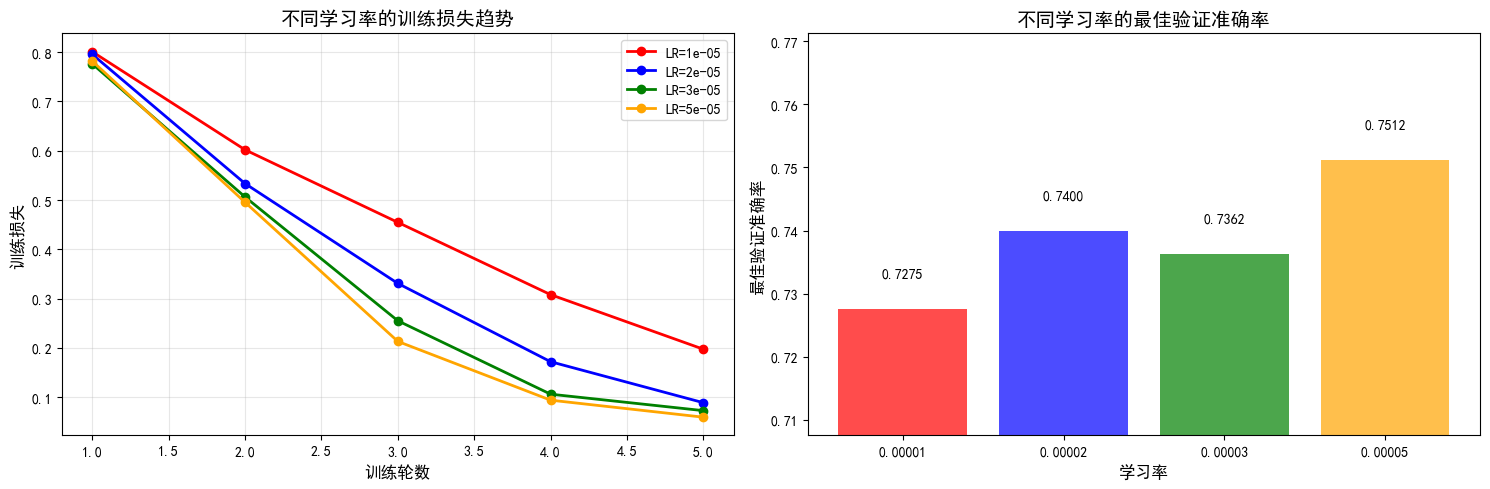

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 
plt.rcParams['axes.unicode_minus'] = False

def plot_tune_results(tune_results):
    """可视化学习率调优结果：2个子图（损失趋势+准确率对比）"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 子图1：不同学习率的训练损失趋势
    colors = ['red', 'blue', 'green', 'orange']
    for i, lr in enumerate(tune_results["lr"]):
        epochs = range(1, len(tune_results["train_losses_per_epoch"][i]) + 1)
        ax1.plot(epochs, tune_results["train_losses_per_epoch"][i], 
                 label=f'LR={lr}', color=colors[i], linewidth=2, marker='o')
    ax1.set_xlabel('训练轮数', fontsize=12)
    ax1.set_ylabel('训练损失', fontsize=12)
    ax1.set_title('不同学习率的训练损失趋势', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 子图2：最佳验证准确率对比（柱状图）
    lrs_str = [f'{lr:.5f}' for lr in tune_results["lr"]]
    ax2.bar(lrs_str, tune_results["best_val_acc"], color=colors, alpha=0.7)
    ax2.set_xlabel('学习率', fontsize=12)
    ax2.set_ylabel('最佳验证准确率', fontsize=12)
    ax2.set_title('不同学习率的最佳验证准确率', fontsize=14, fontweight='bold')
    ax2.set_ylim([min(tune_results["best_val_acc"])-0.02, max(tune_results["best_val_acc"])+0.02])

    # 标注数值
    for i, acc in enumerate(tune_results["best_val_acc"]):
        ax2.text(i, acc+0.005, f'{acc:.4f}', ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('learning_rate_tune_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_final_train_curve(train_losses, val_accs):
    """可视化最终训练曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 损失曲线
    ax1.plot(range(1, len(train_losses)+1), train_losses, color='red', linewidth=2, marker='o')
    ax1.set_xlabel('训练轮数', fontsize=12)
    ax1.set_ylabel('训练损失', fontsize=12)
    ax1.set_title('最终训练损失曲线', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # 准确率曲线
    ax2.plot(range(1, len(val_accs)+1), val_accs, color='blue', linewidth=2, marker='s')
    ax2.set_xlabel('训练轮数', fontsize=12)
    ax2.set_ylabel('验证准确率', fontsize=12)
    ax2.set_title('最终训练验证准确率曲线', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('final_train_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
plot_tune_results(tune_results)

## 4.最优参数训练

In [ ]:
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = optim.AdamW(
    model.parameters(),
    lr=5e-5,          # 对 BERT 友好
    weight_decay=1e-4
)

num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\n=== Epoch [{epoch+1}/{num_epochs}] 开始训练 ===")
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_acc = evaluate(model, val_loader, device)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )

    # 保存验证集最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("保存最佳模型")


=== Epoch [1/10] 开始训练 ===
Epoch [1/10] Train Loss: 0.7650 Val Acc: 0.7488
保存最佳模型

=== Epoch [2/10] 开始训练 ===
Epoch [2/10] Train Loss: 0.4632 Val Acc: 0.7462

=== Epoch [3/10] 开始训练 ===
Epoch [3/10] Train Loss: 0.2053 Val Acc: 0.7500
保存最佳模型

=== Epoch [4/10] 开始训练 ===
Epoch [4/10] Train Loss: 0.0831 Val Acc: 0.7425

=== Epoch [5/10] 开始训练 ===
Epoch [5/10] Train Loss: 0.0439 Val Acc: 0.7312

=== Epoch [6/10] 开始训练 ===
Epoch [6/10] Train Loss: 0.0414 Val Acc: 0.7512
保存最佳模型

=== Epoch [7/10] 开始训练 ===
Epoch [7/10] Train Loss: 0.0306 Val Acc: 0.7450

=== Epoch [8/10] 开始训练 ===
Epoch [8/10] Train Loss: 0.0435 Val Acc: 0.7087

=== Epoch [9/10] 开始训练 ===
Epoch [9/10] Train Loss: 0.0653 Val Acc: 0.7087

=== Epoch [10/10] 开始训练 ===
Epoch [10/10] Train Loss: 0.0572 Val Acc: 0.7462


In [9]:
 # 调超参：权重优化 单独5轮
def tune_weight_decay(weight_decays, num_tune_epochs=5):
    tune_results = {
        "weight_decay": [],
        "best_val_acc": [],
        "train_losses_per_epoch": [],
        "val_accs_per_epoch": []
    }

    for weight_decay in weight_decays:
        print(f"\n=== 权重衰减：{weight_decay} ===")
        # 重新初始化模型
        model = MultimodalSentimentModel(num_classes=3).to(device)
        optimizer = optim.AdamW(
            model.parameters(),lr=5e-5,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        train_losses = []
        val_accs = []
        best_acc = 0.0

        for epoch in range(num_tune_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_acc = evaluate(model, val_loader, device)

            train_losses.append(train_loss)
            val_accs.append(val_acc)
            if val_acc > best_acc:
                best_acc = val_acc

            print(f" Epoch [{epoch+1}/{num_tune_epochs}] | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

        # 保存结果
        tune_results["weight_decay"].append(weight_decay)
        tune_results["best_val_acc"].append(best_acc)
        tune_results["train_losses_per_epoch"].append(train_losses)
        tune_results["val_accs_per_epoch"].append(val_accs)

        # 清理显存
        torch.cuda.empty_cache()

    return tune_results

weight_decays = [1e-4,3e-4, 5e-4]
tune_results = tune_weight_decay(weight_decays, num_tune_epochs=5)


=== 权重衰减：0.0001 ===


d:\Python2\Python311\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python2\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Epoch [1/5] | Train Loss: 0.7606 | Val Acc: 0.7512
 Epoch [2/5] | Train Loss: 0.4517 | Val Acc: 0.7188
 Epoch [3/5] | Train Loss: 0.1948 | Val Acc: 0.7325
 Epoch [4/5] | Train Loss: 0.0929 | Val Acc: 0.7550
 Epoch [5/5] | Train Loss: 0.0539 | Val Acc: 0.7438

=== 权重衰减：0.0003 ===
 Epoch [1/5] | Train Loss: 0.7496 | Val Acc: 0.7462
 Epoch [2/5] | Train Loss: 0.4836 | Val Acc: 0.7275
 Epoch [3/5] | Train Loss: 0.2073 | Val Acc: 0.7362
 Epoch [4/5] | Train Loss: 0.0877 | Val Acc: 0.7512
 Epoch [5/5] | Train Loss: 0.0492 | Val Acc: 0.7438

=== 权重衰减：0.0005 ===
 Epoch [1/5] | Train Loss: 0.7609 | Val Acc: 0.7013
 Epoch [2/5] | Train Loss: 0.4596 | Val Acc: 0.7075
 Epoch [3/5] | Train Loss: 0.1912 | Val Acc: 0.6725
 Epoch [4/5] | Train Loss: 0.0861 | Val Acc: 0.7312
 Epoch [5/5] | Train Loss: 0.0629 | Val Acc: 0.7275


In [16]:
import torch
# 查看GPU显存使用
print(f"GPU可用显存：{torch.cuda.memory_allocated()/1024/1024/1024:.2f} GB")
print(f"GPU总显存：{torch.cuda.get_device_properties(0).total_memory/1024/1024/1024:.2f} GB")
# 强制清空显存
torch.cuda.empty_cache()

GPU可用显存：2.07 GB
GPU总显存：6.00 GB


In [17]:
model = MultimodalSentimentModel(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # 损失函数
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-5,          # 对 BERT 友好
    weight_decay=2e-4
)

num_epochs = 10
best_val_acc = 0.0
torch.cuda.empty_cache()  # 清理上一次训练的显存碎片
for epoch in range(num_epochs):
    print(f"\n=== Epoch [{epoch+1}/{num_epochs}] 开始训练 ===")
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_acc, val_loss = evaluate(model, val_loader, device, criterion)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Acc: {val_acc:.4f} "
        f"Val Loss: {val_loss:.4f}"
    )

    # 保存验证集最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("保存最佳模型")



=== Epoch [1/10] 开始训练 ===
Epoch [1/10] Train Loss: 0.9371 Val Acc: 0.6512 Val Loss: 0.8392
保存最佳模型

=== Epoch [2/10] 开始训练 ===
Epoch [2/10] Train Loss: 0.8104 Val Acc: 0.7212 Val Loss: 0.7699
保存最佳模型

=== Epoch [3/10] 开始训练 ===
Epoch [3/10] Train Loss: 0.7014 Val Acc: 0.7225 Val Loss: 0.7725
保存最佳模型

=== Epoch [4/10] 开始训练 ===
Epoch [4/10] Train Loss: 0.6235 Val Acc: 0.7388 Val Loss: 0.7650
保存最佳模型

=== Epoch [5/10] 开始训练 ===
Epoch [5/10] Train Loss: 0.5521 Val Acc: 0.7588 Val Loss: 0.7752
保存最佳模型

=== Epoch [6/10] 开始训练 ===
Epoch [6/10] Train Loss: 0.4835 Val Acc: 0.7013 Val Loss: 0.8405

=== Epoch [7/10] 开始训练 ===
Epoch [7/10] Train Loss: 0.4359 Val Acc: 0.7350 Val Loss: 0.8087

=== Epoch [8/10] 开始训练 ===
Epoch [8/10] Train Loss: 0.3908 Val Acc: 0.7438 Val Loss: 0.8309

=== Epoch [9/10] 开始训练 ===
Epoch [9/10] Train Loss: 0.3715 Val Acc: 0.7325 Val Loss: 0.8513

=== Epoch [10/10] 开始训练 ===
Epoch [10/10] Train Loss: 0.3629 Val Acc: 0.7238 Val Loss: 0.9037
